In [10]:
import os, json
import pickle
import pandas as pd
import numpy as  np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sp
from sklearn.metrics import classification_report

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [11]:
# !pip install pymc

In [12]:
# ! pip install arviz

In [13]:
# !pip install graphviz

In [14]:
# !apt-get install graphviz -y

## Data

In [15]:
DATA_PATH='data/raw/'
df=pd.DataFrame()
for file in os.listdir(DATA_PATH):
    df_=pd.read_csv(f'{DATA_PATH}{file}')
    df=pd.concat([df, df_])
df.shape

(180524, 13)

In [16]:
df.head(10)

,EKSAMI_SOORITAJA,KUUPAEV,BYROO,KATEGOORIA,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND,KESTUS,KATK_POHJUS,MITTEARVESTATUD,VEAD
0,fb6f44a4e71821f2,2023-01,Valga,B,101,osaühing Kursus & Ko,E,bf2b7218d36e2a3d,MITTE_SOORITATUD,28.0,NaN,LIIKLUSOHUTUS|TEELPUSIMINE,NaN
1,82ed52e5990f8204,2023-01,Jõgeva,B,101,OÜ AUTOSÕIT,E,844452b4e4bac2ef,SOORITATUD,44.0,NaN,NaN,NaN
2,e72eeaf255d74785,2023-01,Narva,B,101|78,OSAÜHING ERMAN AUTOKOOL,E,d67d168bc8d04278,SOORITATUD,45.0,NaN,NaN,NaN
3,d0dd38daf0397c9d,2023-01,Valga,B,101,osaühing Kursus & Ko,J,bf2b7218d36e2a3d,MITTE_SOORITATUD,33.0,NaN,LIIKLUSOHUTUS,NaN
4,655194a10a21cd56,2023-01,Paide,B,101|78,Autokool Drive OÜ,E,f6097462dafbd97c,MITTE_SOORITATUD,18.0,NaN,PARKIMINE_MANOOVRIGA,EBAPIISAV_ETTEVALMISTUS|PARKIMINE_MARGISEL
5,761396cbfe80ec42,2023-01,Valga,B,101,osaühing Kursus & Ko,E,faeaf99580d6be30,SOORITATUD,42.0,NaN,NaN,NaN
6,de824d8083a1d269,2023-01,Rapla,B,101,Silver Autokool OÜ,E,4b9e369e12d8f969,SOORITATUD,49.0,NaN,NaN,NaN
7,44e0c0d162afebb0,2023-01,Narva,B,101,Osaühing STALIKA-VEOD,E,166c8268fe1b2ec1,SOORITATUD,41.0,NaN,NaN,NaN
8,808f4666542a6bc8,2023-01,Narva,B,101,Mittetulundusühing Autobis,E,166c8268fe1b2ec1,MITTE_SOORITATUD,47.0,NaN,LIIKLUSOHUTUS|PARKIMINE_MANOOVRIGA,OHUSTAMINE
9,cdc8a8cc2ddeca47,2023-01,Tartu,B,101|78,ROPKA ERAKOOL OÜ,NaN,c68c6310b2fe1124,EI_ILMUNUD_KOHALE,NaN,EI_ILMUNUD,NaN,NaN


In [17]:
df.tail(10)

,EKSAMI_SOORITAJA,KUUPAEV,BYROO,KATEGOORIA,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND,KESTUS,KATK_POHJUS,MITTEARVESTATUD,VEAD
43899,2d3d0275e6f87c93,2024-01,Tallinn,C,NaN,Aktsiaselts Odium,E,a1d9e404aeec83d1,SOORITATUD,58.0,NaN,NaN,NaN
43900,662c8bfc52935409,2024-08,Tartu,C,NaN,OÜ AUTOSÕIT,E,b89f5e763b05e7a7,MITTE_SOORITATUD,4.0,NaN,TAGUR_BOKS,VASTU_KOONUST
43901,8431c357abeb9177,2024-05,Tallinn,A,NaN,Ametikoolitus OÜ,E,b353c311e671711a,SOORITATUD,44.0,NaN,NaN,NaN
43902,41f599b18e8d11a3,2024-09,Rapla,A,NaN,Rapla Autokool OÜ,E,b353c311e671711a,SOORITATUD,43.0,NaN,NaN,NaN
43903,7ba322b8b5eb8552,2024-02,Pärnu,CE,NaN,osaühing Aide Autokool,E,c347692cf48342d6,SOORITATUD,64.0,NaN,NaN,NaN
43904,2455ec4557fca42a,2024-02,Jõhvi,C,NaN,Tõnis Mägi Autokool OÜ,E,268b141c418a500d,SOORITATUD,53.0,NaN,NaN,NaN
43905,15758d080522a0f9,2024-08,Tallinn,A,NaN,Ametikoolitus OÜ,E,b353c311e671711a,SOORITATUD,50.0,NaN,NaN,NaN
43906,dd65c5b9c581747f,2024-05,Tallinn,A,NaN,Sky Autokool OÜ,NaN,c68c6310b2fe1124,EI_ILMUNUD_KOHALE,NaN,EI_ILMUNUD,NaN,NaN
43907,b9f5d194b08c7496,2024-03,Jõhvi,C,NaN,OÜ AUTOSÕIT,E,c74b0de43bcd0b0f,SOORITATUD,55.0,NaN,NaN,NaN
43908,4674e35f5ec54f3f,2024-10,Võru,C,NaN,Tugev Partner OÜ,E,5f2e29794998d365,SOORITATUD,60.0,NaN,NaN,NaN


In [18]:
df.describe(include='all')

,EKSAMI_SOORITAJA,KUUPAEV,BYROO,KATEGOORIA,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND,KESTUS,KATK_POHJUS,MITTEARVESTATUD,VEAD
count,180524,180524,180524,180524,129745,170298,175589,180524,180524,175214.000000,5320,77419,18738
unique,91167,47,17,14,11,366,2,59,4,NaN,7,2726,418
top,2a1562b30ea0f71a,2022-05,Tallinn,B,101,OÜ AUTOSÕIT,E,bf2b7218d36e2a3d,SOORITATUD,NaN,EI_ILMUNUD,LIIKLUSOHUTUS,AJA_YLETAMINE
freq,23,4792,68889,128633,96651,18021,165004,5320,97720,NaN,3275,11518,2724
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.991182,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.175641,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,NaN,NaN,NaN


## cols2keep

In [19]:
df.KATEGOORIA.value_counts()

KATEGOORIA
B      128633
C       13773
A       10841
CE       9903
BE       5431
T        3183
D        2860
AM       2313
A2       2039
A1       1239
C1        238
Z          64
C1E         6
B1          1
Name: count, dtype: int64

In [20]:
df_b=df[(df.KATEGOORIA.isin(['C', 'CE']))&(df.SEISUND.isin(['MITTE_SOORITATUD', 'SOORITATUD']))]
df_b.shape

(23152, 13)

In [27]:
COLS2KEEP=['KUUPAEV', 'BYROO', 'ERITINGIMUSED','VIIMANE_AUTOKOOL','SOIDUOPETAJA_KAASAS', 'EKSAMINEERIJA', 'SEISUND']

In [28]:
df_b_sub=df_b[COLS2KEEP]

In [23]:
df_b_sub.head(10)

,KUUPAEV,BYROO,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND
13360,2023-05,Tallinn,101,Aktsiaselts Odium,E,4ee4a4702131dac3,MITTE_SOORITATUD
14763,2023-06,Tallinn,101,Aktsiaselts Odium,E,a1d9e404aeec83d1,SOORITATUD
30840,2023-11,Tartu,78,VPK Koolitus OÜ,E,b89f5e763b05e7a7,SOORITATUD
30855,2023-11,Tartu,78,VPK Koolitus OÜ,E,b89f5e763b05e7a7,SOORITATUD
32365,2023-12,Haapsalu,78,Positiivne OÜ,E,31451a368e962058,SOORITATUD
32688,2023-12,Tartu,78,VPK Koolitus OÜ,E,844452b4e4bac2ef,SOORITATUD
32700,2023-12,Rakvere,78,Mittetulundusühing Viljandi Autom,E,4141299ff500eb11,SOORITATUD
32776,2023-12,Tartu,78,VPK Koolitus OÜ,E,844452b4e4bac2ef,SOORITATUD
32789,2023-12,Tartu,78,VPK Koolitus OÜ,E,844452b4e4bac2ef,SOORITATUD
33170,2023-05,Võru,NaN,SÕIDUÕPPE OÜ,E,bf2b7218d36e2a3d,SOORITATUD


In [25]:
df_b_sub.SOIDUOPETAJA_KAASAS.value_counts()

SOIDUOPETAJA_KAASAS
E    22921
J      231
Name: count, dtype: int64

In [29]:
df_b_sub.ERITINGIMUSED.value_counts()

ERITINGIMUSED
78     13
101     2
Name: count, dtype: int64

In [30]:
df_b_sub.tail(10)

,KUUPAEV,BYROO,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND
43892,2024-05,Rapla,NaN,NaN,E,b3e368548c216eb8,SOORITATUD
43893,2024-09,Pärnu,NaN,osaühing Aide Autokool,E,c347692cf48342d6,SOORITATUD
43897,2024-08,Tallinn,NaN,Aktsiaselts Odium,E,a1d9e404aeec83d1,MITTE_SOORITATUD
43898,2024-10,Rakvere,NaN,Osaühing TAPA AUTOKOOL,E,d15d81b55baf64ed,SOORITATUD
43899,2024-01,Tallinn,NaN,Aktsiaselts Odium,E,a1d9e404aeec83d1,SOORITATUD
43900,2024-08,Tartu,NaN,OÜ AUTOSÕIT,E,b89f5e763b05e7a7,MITTE_SOORITATUD
43903,2024-02,Pärnu,NaN,osaühing Aide Autokool,E,c347692cf48342d6,SOORITATUD
43904,2024-02,Jõhvi,NaN,Tõnis Mägi Autokool OÜ,E,268b141c418a500d,SOORITATUD
43907,2024-03,Jõhvi,NaN,OÜ AUTOSÕIT,E,c74b0de43bcd0b0f,SOORITATUD
43908,2024-10,Võru,NaN,Tugev Partner OÜ,E,5f2e29794998d365,SOORITATUD


In [31]:
df_b_sub.describe(include='all')

,KUUPAEV,BYROO,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND
count,23152,23152,15,21524,23152,23152,23152
unique,47,13,2,76,2,44,2
top,2022-11,Tallinn,78,Ametikoolitus OÜ,E,d15d81b55baf64ed,SOORITATUD
freq,793,8238,13,3609,22921,1931,16330


In [32]:
df_b_sub.SEISUND.value_counts()

SEISUND
SOORITATUD          16330
MITTE_SOORITATUD     6822
Name: count, dtype: int64

In [33]:
df_b[df_b.SEISUND=='KATKESTATUD']

,EKSAMI_SOORITAJA,KUUPAEV,BYROO,KATEGOORIA,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND,KESTUS,KATK_POHJUS,MITTEARVESTATUD,VEAD


## Keep eritingimused 101, 78

In [34]:
# df_b_sub['eri_101']=np.where(df_b_sub.ERITINGIMUSED.str.contains('101'), 1, 0)
# df_b_sub['eri_78']=np.where(df_b_sub.ERITINGIMUSED.str.contains('78'), 1, 0)
# df_b_sub['eri_78_c'] = df_b_sub['eri_78'] - df_b_sub['eri_78'].mean()

In [35]:
df_b_sub.shape

(23152, 7)

In [36]:
# df_b_sub=df_b_sub[df_b_sub.eri_101==1]
# df_b_sub.shape

In [37]:
# df_b_sub['eri_96']=np.where(df_b_sub.ERITINGIMUSED.str.contains('96'), 1, 0)
# df_b_sub=df_b_sub[df_b_sub.eri_96==0]
# df_b_sub.shape

## Recode y

In [38]:
df_b_sub['y']=df_b_sub.SEISUND.replace({'SOORITATUD':1.0, 'MITTE_SOORITATUD':0.0})

/tmp/ipykernel_204/645445151.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_b_sub['y']=df_b_sub.SEISUND.replace({'SOORITATUD':1.0, 'MITTE_SOORITATUD':0.0})
/tmp/ipykernel_204/645445151.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_sub['y']=df_b_sub.SEISUND.replace({'SOORITATUD':1.0, 'MITTE_SOORITATUD':0.0})


In [39]:
df_b_sub.shape

(23152, 8)

In [40]:
df_b_sub.SEISUND.value_counts()

SEISUND
SOORITATUD          16330
MITTE_SOORITATUD     6822
Name: count, dtype: int64

In [41]:
epsilon = 1e-6  # small constant to avoid direct 0
df_b_sub['y_transformed'] =df_b_sub['y']* (1 - 2*epsilon) + epsilon

/tmp/ipykernel_204/644185622.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_sub['y_transformed'] =df_b_sub['y']* (1 - 2*epsilon) + epsilon


## Recode others

In [42]:
df_b_sub['VIIMANE_AUTOKOOL'] = df_b_sub['VIIMANE_AUTOKOOL'].fillna('UNKNOWN')

count_examiner=df_b_sub['EKSAMINEERIJA'].str.lower().value_counts()
examiners2keep=count_examiner[count_examiner>20].index
df_b_sub['EKSAMINEERIJA_CLEAN'] = np.where(df_b_sub['EKSAMINEERIJA'].isin(examiners2keep), df_b_sub['EKSAMINEERIJA'], 'grupp')

examiner_to_idx = {examiner: idx for idx, examiner in enumerate(df_b_sub['EKSAMINEERIJA_CLEAN'].unique())}
idx_to_examiner={v:k for k,v in examiner_to_idx.items()}
school_to_idx = {school: idx for idx, school in enumerate(df_b_sub['VIIMANE_AUTOKOOL'].str.lower().unique())}
idx_to_school={v:k for k,v in school_to_idx.items()}

# Convert categories to indices
df_b_sub['examiner_idx'] = df_b_sub['EKSAMINEERIJA_CLEAN'].map(examiner_to_idx)
df_b_sub['school_idx'] = df_b_sub['VIIMANE_AUTOKOOL'].str.lower().map(school_to_idx)

# Convert target to binary
df_b_sub['passed'] = (df_b_sub['SEISUND'] == 'SOORITATUD').astype(int)

/tmp/ipykernel_204/272643644.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_sub['VIIMANE_AUTOKOOL'] = df_b_sub['VIIMANE_AUTOKOOL'].fillna('UNKNOWN')
/tmp/ipykernel_204/272643644.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_sub['EKSAMINEERIJA_CLEAN'] = np.where(df_b_sub['EKSAMINEERIJA'].isin(examiners2keep), df_b_sub['EKSAMINEERIJA'], 'grupp')
/tmp/ipykernel_204/272643644.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [43]:
count_schools=df_b_sub['VIIMANE_AUTOKOOL'].str.lower().value_counts()
count_schools[count_schools>20]

VIIMANE_AUTOKOOL
ametikoolitus oü                       3609
oü autosõit                            2374
aktsiaselts odium                      2312
osaühing tapa autokool                 1696
unknown                                1628
tugev partner oü                       1256
mittetulundusühing viljandi autom      1202
osaühing aide autokool                  997
osaühing kadrioru autokool              893
tõnis mägi autokool oü                  786
stalker autokool osaühing               759
sõiduõppe oü                            473
rakvere autokool oü                     470
osaühing autokool mewo                  432
osaühing lrk autokoolitus               401
noorsoo assotsiatsioon kiirus           359
haja autokooli osaühing                 357
oü taavo tenno autokool                 318
positiivne oü                           279
mittetulundusühing narva autom          274
autokoolitus oü                         260
osaühing vasara autokool                224
osaühing järva 

In [44]:
# First create index mapping for BYROO
byroo_to_idx = {byroo: idx for idx, byroo in enumerate(df_b_sub['BYROO'].unique())}
idx_to_byroo={v:k for k,v in byroo_to_idx.items()}
n_byroos = len(byroo_to_idx)
# Convert BYROO to indices
df_b_sub['byroo_idx'] = df_b_sub['BYROO'].map(byroo_to_idx)

In [45]:
byroo_to_idx

{'Tallinn': 0,
 'Tartu': 1,
 'Haapsalu': 2,
 'Rakvere': 3,
 'Võru': 4,
 'Jõhvi': 5,
 'Narva': 6,
 'Paide': 7,
 'Rapla': 8,
 'Pärnu': 9,
 'Viljandi': 10,
 'Kuressaare': 11,
 'Valga': 12}

In [46]:
# Get dimensions for our hierarchical components
n_examiners = len(examiner_to_idx)
n_schools = len(school_to_idx)

In [47]:
n_examiners

42

## Soiduopetaja kaasas

In [48]:
df_b_sub.groupby('SOIDUOPETAJA_KAASAS')['y'].mean()

SOIDUOPETAJA_KAASAS
E    0.705947
J    0.645022
Name: y, dtype: float64

In [49]:
df_b_sub['teacher_present'] = (df_b_sub['SOIDUOPETAJA_KAASAS'] == 'J').astype(int)
#for faster sampling
df_b_sub['teacher_present_c'] = df_b_sub['teacher_present'] - df_b_sub['teacher_present'].mean()

## Model

In [50]:
with pm.Model() as model:
    intercept_raw = pm.Normal('intercept_raw', mu=0, sigma=1)
    intercept_sigma = pm.HalfStudentT('intercept_sigma', nu=3, sigma=0.05)
    intercept = pm.Deterministic('intercept', intercept_raw * intercept_sigma)
    
    examiner_sigma = pm.HalfCauchy('examiner_sigma', beta=0.05)
    examiner_raw = pm.Normal('examiner_raw', mu=0, sigma=1, shape=n_examiners)
    examiner_effects = pm.Deterministic('examiner_effects', examiner_raw * examiner_sigma)
    
    school_sigma = pm.HalfStudentT('school_sigma', nu=3, sigma=0.5)
    school_raw = pm.Normal('school_raw', mu=0, sigma=1, shape=n_schools)
    school_effects = pm.Deterministic('school_effects', school_raw * school_sigma)
    
    byroo_sigma = pm.HalfStudentT('byroo_sigma', nu=3, sigma=0.1)
    byroo_raw = pm.Normal('byroo_raw', mu=0, sigma=1, shape=n_byroos)
    byroo_effects = pm.Deterministic('byroo_effects', byroo_raw * byroo_sigma)
    
    teacher_effect = pm.Normal('teacher_effect', mu=0, sigma=0.5)
    
    # Combine all predictors
    logit = (intercept + 
             examiner_effects[df_b_sub['examiner_idx']] +
             school_effects[df_b_sub['school_idx']] +
             byroo_effects[df_b_sub['byroo_idx']] +
             teacher_effect*df_b_sub['teacher_present_c']
            )
        
     # Transform mu to be between 0 and 1
    mu_bounded = pm.math.invlogit(logit)
    
    # Use transformed data with Beta likelihood
    alpha = pm.HalfNormal('alpha', sigma=1)
    y = pm.Beta('y', 
                    alpha=mu_bounded*alpha, 
                    beta=(1-mu_bounded)*alpha, 
                    observed=df_b_sub['y_transformed'])

## Save model graph

In [51]:
with model:
    graph = pm.model_to_graphviz()
    graph.render('plots/model_c_cat_v1_graph', format='png', cleanup=True)

## Sample

In [52]:
with model:
    trace = pm.sample(
        draws=4000,          
        tune=4000,         
        chains=4,            
        init='advi',  
        return_inferencedata=True,
        target_accept=0.95   
    )

Initializing NUTS using advi...


Output()

Convergence achieved at 24900
Interrupted at 24,899 [12%]: Average Loss = -2.1141e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_raw, intercept_sigma, examiner_sigma, examiner_raw, school_sigma, school_raw, byroo_sigma, byroo_raw, teacher_effect, alpha]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 3628 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.


## Diagnostic

In [53]:
df_summary=az.summary(trace)

In [54]:
df_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept_raw,1.781,0.639,0.626,2.957,0.012,0.008,3124.0,4632.0,1.0
examiner_raw[0],-0.496,0.305,-1.054,0.088,0.004,0.003,6948.0,8782.0,1.0
examiner_raw[1],-0.331,0.344,-0.968,0.329,0.004,0.003,9259.0,10031.0,1.0
examiner_raw[2],0.309,0.478,-0.579,1.219,0.004,0.003,13109.0,11948.0,1.0
examiner_raw[3],0.944,0.513,-0.007,1.921,0.005,0.004,11373.0,11603.0,1.0
...,...,...,...,...,...,...,...,...,...
byroo_effects[8],-0.016,0.076,-0.157,0.132,0.001,0.001,7452.0,10122.0,1.0
byroo_effects[9],-0.131,0.074,-0.271,0.005,0.001,0.001,7175.0,10125.0,1.0
byroo_effects[10],0.003,0.078,-0.150,0.147,0.001,0.001,7581.0,9779.0,1.0
byroo_effects[11],0.090,0.094,-0.081,0.277,0.001,0.001,7860.0,9657.0,1.0


In [55]:
df_summary[df_summary.r_hat>1.05].shape

(0, 9)

In [56]:
df_summary[df_summary.r_hat>1.01].shape

(0, 9)


Model Parameter Summary:


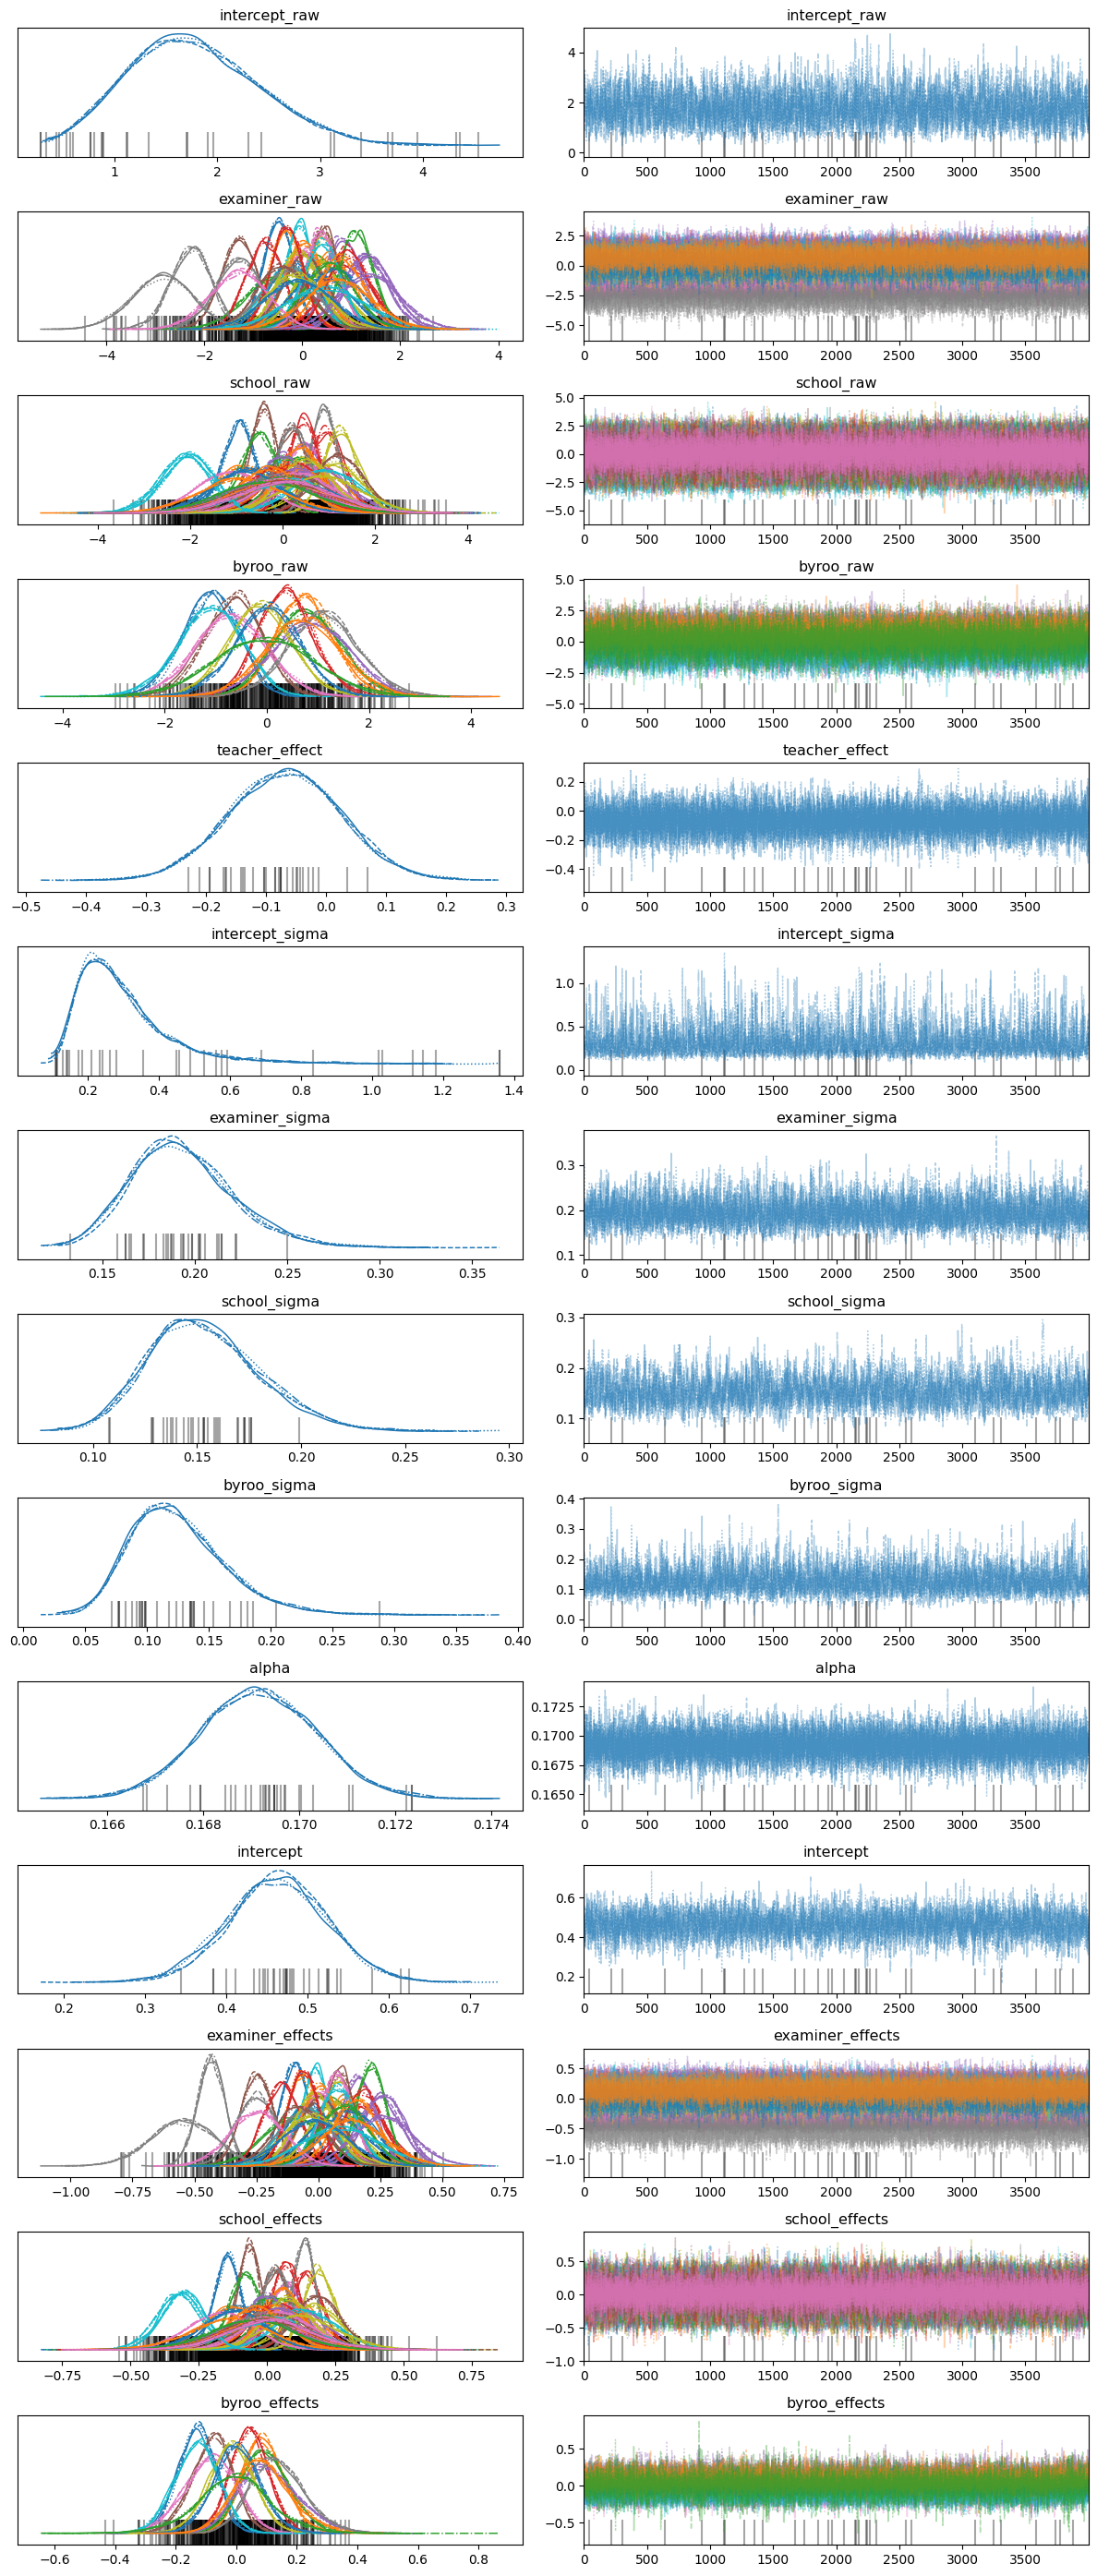

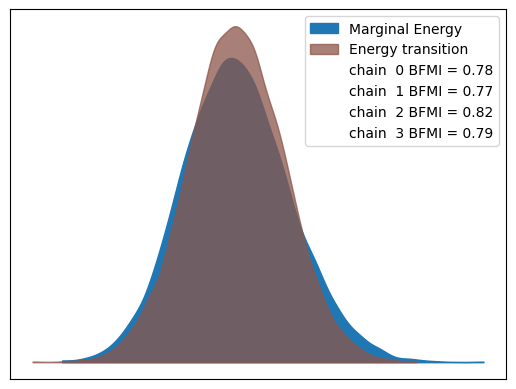


Number of divergent samples:
<xarray.DataArray 'diverging' ()> Size: 8B
array(32)


In [57]:
# Basic convergence diagnostics
print("\nModel Parameter Summary:")
summary = az.summary(trace, kind='diagnostics')

# Plot trace diagnostics
az.plot_trace(trace)
plt.tight_layout()
plt.show()

# Plot energy diagnostics
az.plot_energy(trace)
plt.show()

# Check for divergences
print("\nNumber of divergent samples:")
print(trace.sample_stats.diverging.sum())

In [58]:
df_summary[df_summary.r_hat>1.01]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat


## Save trace

In [59]:
trace.to_netcdf("models/soidueksam_c_kat_multiyear_v1.nc")

'models/soidueksam_c_kat_multiyear_v1.nc'

## Load trace

In [60]:
trace = az.from_netcdf("models/soidueksam_c_kat_multiyear_v1.nc")

## overall exam success

In [61]:
def get_average_success_probability(trace):
    # Get intercept (baseline)
    intercept = trace.posterior['intercept'].values
    
    # Convert to probability using inverse logit
    baseline_prob = 1 / (1 + np.exp(-intercept))
    results = {
        'mean': np.mean(baseline_prob),
        'std': np.std(baseline_prob),
        'lower_ci': np.percentile(baseline_prob, 2.5),
        'upper_ci': np.percentile(baseline_prob, 97.5)
    }
    
    print("Overall Success Probability:")
    print(f"Mean: {results['mean']:.3f}")
    print(f"95% CI: [{results['lower_ci']:.3f}, {results['upper_ci']:.3f}]")
    
    return results

average_prob = get_average_success_probability(trace)
average_prob

Overall Success Probability:
Mean: 0.614
95% CI: [0.584, 0.642]


{'mean': 0.6135904719924307,
 'std': 0.014571666069178434,
 'lower_ci': 0.584373142564752,
 'upper_ci': 0.641846253417423}

In [62]:
df_b_sub.y.mean()

0.7053386316516932

## Factors that contribute the most

<Figure size 1800x500 with 0 Axes>

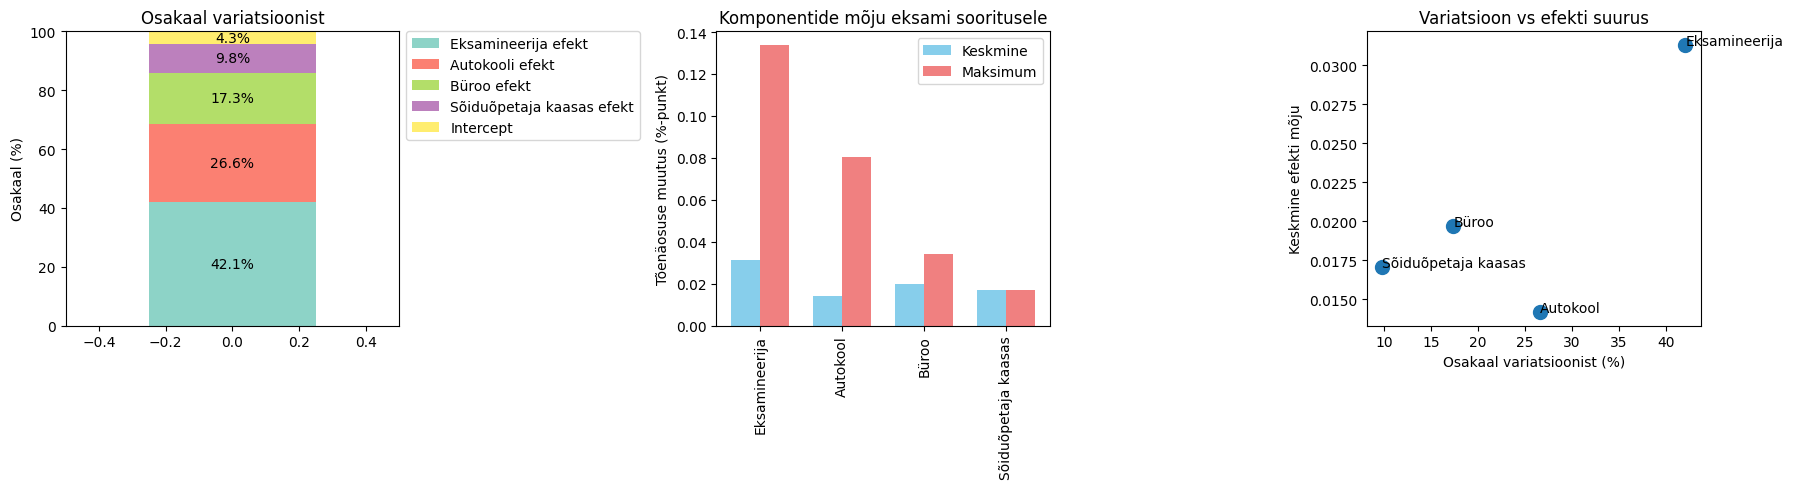

In [63]:
def analyze_component_contributions(trace):
    # Get components
    intercept_var = np.var(trace.posterior['intercept'].values)
    examiner_var = np.var(trace.posterior['examiner_effects'].values.reshape(-1))
    school_var = np.var(trace.posterior['school_effects'].values.reshape(-1))
    byroo_var = np.var(trace.posterior['byroo_effects'].values.reshape(-1))
    teacher_var = np.var(trace.posterior['teacher_effect'].values)
    
    # Calculate total variance
    total_var = (intercept_var + examiner_var + school_var + byroo_var + 
                 teacher_var )
    
    # Calculate proportions
    contributions = pd.Series({
        'Intercept': intercept_var/total_var,
        'Eksamineerija efekt': examiner_var/total_var,
        'Autokooli efekt': school_var/total_var,
        'Büroo efekt': byroo_var/total_var,
        'Sõiduõpetaja kaasas efekt': teacher_var/total_var,
    })
    
    return contributions * 100  # Convert to percentages

def logit_to_prob_change(effect):
    base_prob = 1 / (1 + np.exp(-0))  # 0.5
    new_prob = 1 / (1 + np.exp(-(0 + effect)))
    return new_prob - base_prob
    
    
def analyze_effect_sizes(trace, return_df=False):
    # Get absolute mean effects
    examiner_effects = np.abs(np.mean(trace.posterior['examiner_effects'].values, axis=(0,1)))
    school_effects = np.abs(np.mean(trace.posterior['school_effects'].values, axis=(0,1)))
    byroo_effects = np.abs(np.mean(trace.posterior['byroo_effects'].values, axis=(0,1)))
    teacher_effect = np.abs(np.mean(trace.posterior['teacher_effect'].values))

    result = {
        'Eksamineerija': {'mean': logit_to_prob_change(examiner_effects.mean()), 'max': logit_to_prob_change(examiner_effects.max())},
        'Autokool': {'mean': logit_to_prob_change(school_effects.mean()), 'max': logit_to_prob_change(school_effects.max())},
        'Büroo': {'mean': logit_to_prob_change(byroo_effects.mean()), 'max': logit_to_prob_change(byroo_effects.max())},
        'Sõiduõpetaja kaasas': {'mean': logit_to_prob_change(teacher_effect), 'max': logit_to_prob_change(teacher_effect)}
    }
    
    if return_df:
        return pd.DataFrame(result)
    return result

def plot_model_contributions(trace):
    # Get contributions
    contributions = analyze_component_contributions(trace)
    contributions=contributions.sort_values(ascending=False)
    
    
    # Create figure with more width for legend
    plt.figure(figsize=(18, 5))
    
    # Create figure with more width for legend
    plt.figure(figsize=(18, 5))
    
    # 1. Stacked Bar Plot
    plt.subplot(131)
    colors = plt.cm.Set3(np.linspace(0, 1, len(contributions)))
    
    # Create bars one by one to properly set up legend
    bottom = 0
    bars = []
    for i, (name, value) in enumerate(contributions.items()):
        bar = plt.bar(0, value, bottom=bottom, color=colors[i], width=0.5, label=name)
        plt.text(0, bottom + value/2, f'{value:.1f}%', ha='center', va='center')
        bottom += value
        bars.append(bar)
    
    plt.xlim(-0.5, 0.5)
    plt.ylim(0, 100)
    plt.ylabel('Osakaal (%)')
    plt.title('Osakaal variatsioonist')
    
    # Add legend
    plt.legend(bbox_to_anchor=(1.02, 1), 
              loc='upper left',
              borderaxespad=0)
    
    # 2. Bar Plot with Effect Sizes
    effect_sizes = analyze_effect_sizes(trace)
    plt.subplot(132)
    components = list(effect_sizes.keys())
    means = [d['mean'] for d in effect_sizes.values()]
    maxes = [d['max'] for d in effect_sizes.values()]
    
    x = np.arange(len(components))
    width = 0.35
    
    plt.bar(x - width/2, means, width, label='Keskmine', color='skyblue')
    plt.bar(x + width/2, maxes, width, label='Maksimum', color='lightcoral')
    plt.xticks(x, components, rotation=90)
    plt.title('Komponentide mõju eksami sooritusele')
    plt.ylabel('Tõenäosuse muutus (%-punkt)')
    plt.legend()
    
    # 3. Scatter Plot: Variance vs Mean Effect
    plt.subplot(133)
    # Map component names to contribution names
    name_map = {
        'Eksamineerija': 'Eksamineerija efekt',
        'Büroo': 'Büroo efekt',
        'Autokool': 'Autokooli efekt',
        'Month': 'Month Effects',
        'Sõiduõpetaja kaasas':'Sõiduõpetaja kaasas efekt',
        'Eri101':'Eri101'
        
    }
    matched_contributions = [contributions[name_map[c]] for c in components]
    
    plt.scatter(matched_contributions, means, s=100)
    for i, txt in enumerate(components):
        plt.annotate(txt, (matched_contributions[i], means[i]))
    plt.xlabel('Osakaal variatsioonist (%)')
    plt.ylabel('Keskmine efekti mõju')
    plt.title('Variatsioon vs efekti suurus')
    
    plt.tight_layout()
    plt.show()
    
plot_model_contributions(trace)

## Visualize effect contributions

In [64]:
df_b_sub.columns

Index(['KUUPAEV', 'BYROO', 'ERITINGIMUSED', 'VIIMANE_AUTOKOOL',
       'SOIDUOPETAJA_KAASAS', 'EKSAMINEERIJA', 'SEISUND', 'y', 'y_transformed',
       'EKSAMINEERIJA_CLEAN', 'examiner_idx', 'school_idx', 'passed',
       'byroo_idx', 'teacher_present', 'teacher_present_c'],
      dtype='object')

In [65]:
df_b_sub=df_b_sub.reset_index(drop=True)


Probability changes:
Intercept: 0.114
Eksamineerija: -0.023
Autokool: -0.035
Büroo: -0.033
Sõiduõpetaja: 0.000

Final probability: 0.523
Actual outcome: 0.000


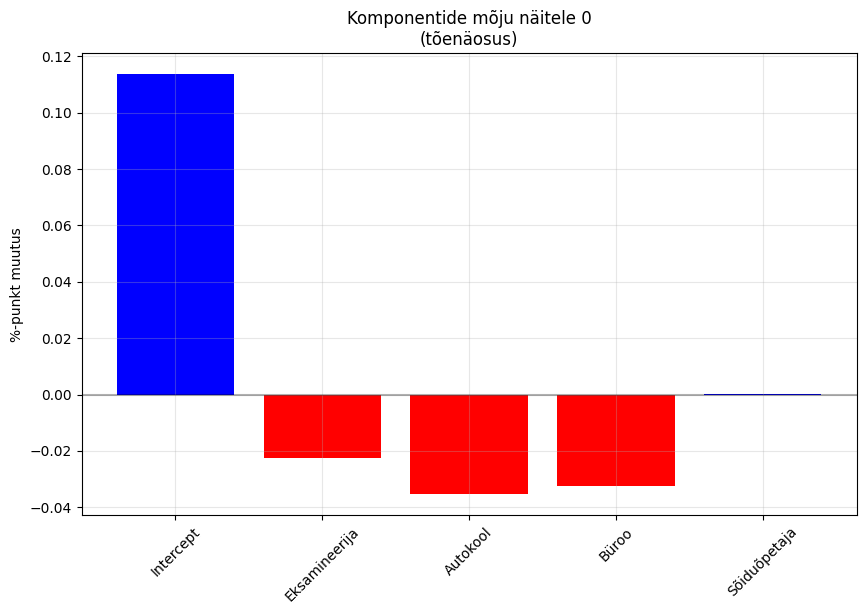

In [66]:
# Get posterior means
examiner_effects_mean = trace.posterior['examiner_effects'].mean(dim=('chain', 'draw'))
school_effects_mean = trace.posterior['school_effects'].mean(dim=('chain', 'draw'))
byroo_effects_mean = trace.posterior['byroo_effects'].mean(dim=('chain', 'draw'))
teacher_effect_mean = trace.posterior['teacher_effect'].mean(dim=('chain', 'draw'))
intercept_effect_mean = float(trace.posterior['intercept'].mean())

def plot_effects_breakdown_prob(sample_idx):
    # Get base effects (logit scale)
    effects = {
        'Intercept': intercept_effect_mean,
        'Eksamineerija': examiner_effects_mean[df_b_sub['examiner_idx'].iloc[sample_idx]],
        'Autokool': school_effects_mean[df_b_sub['school_idx'].iloc[sample_idx]],
        'Büroo': byroo_effects_mean[df_b_sub['byroo_idx'].iloc[sample_idx]],
        'Sõiduõpetaja' : teacher_effect_mean*df_b_sub['teacher_present_c'].iloc[sample_idx]
    }
    
    # Convert to probability changes
    prob_changes = {}
    cumulative = 0
    for k, v in effects.items():
        prev_prob = sp.expit(cumulative)
        cumulative += v
        new_prob = sp.expit(cumulative)
        prob_changes[k] = new_prob - prev_prob
    
    # Plot
    plt.figure(figsize=(10, 6))
    colors = ['blue' if v >= 0 else 'red' for v in prob_changes.values()]
    plt.bar(prob_changes.keys(), prob_changes.values(), color=colors)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title(f'Komponentide mõju näitele {sample_idx}\n(tõenäosus)')
    plt.ylabel('%-punkt muutus')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Print values
    print("\nProbability changes:")
    for k, v in prob_changes.items():
        print(f"{k}: {v:.3f}")
    print(f"\nFinal probability: {sp.expit(sum(effects.values())):.3f}")
    print(f"Actual outcome: {df_b_sub['y_transformed'].iloc[sample_idx]:.3f}")
    
plot_effects_breakdown_prob(0)


Probability changes:
Intercept: 0.114
Eksamineerija: -0.015
Autokool: -0.035
Büroo: -0.032
Sõiduõpetaja: 0.000

Final probability: 0.531
Actual outcome: 1.000


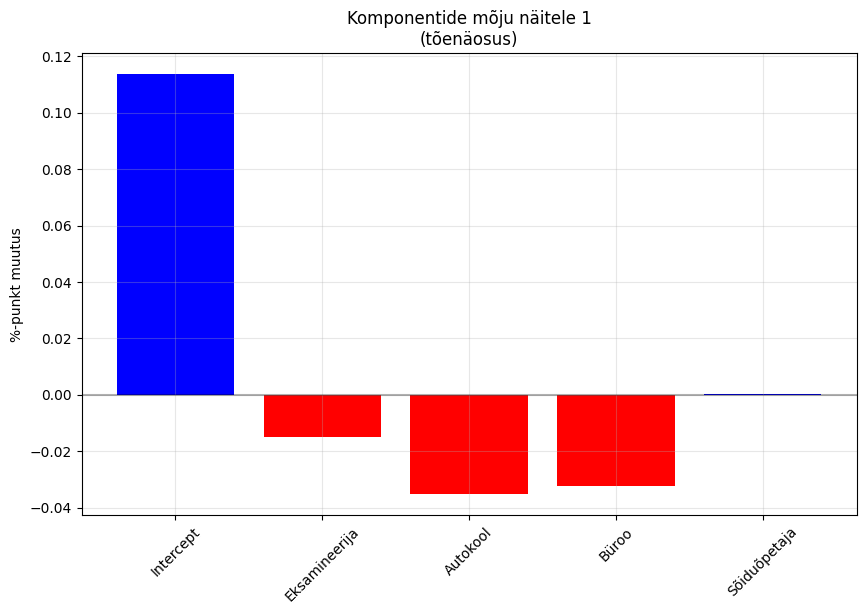

In [67]:
plot_effects_breakdown_prob(1)


Probability changes:
Intercept: 0.114
Eksamineerija: 0.020
Autokool: 0.043
Büroo: 0.010
Sõiduõpetaja: 0.000

Final probability: 0.686
Actual outcome: 1.000


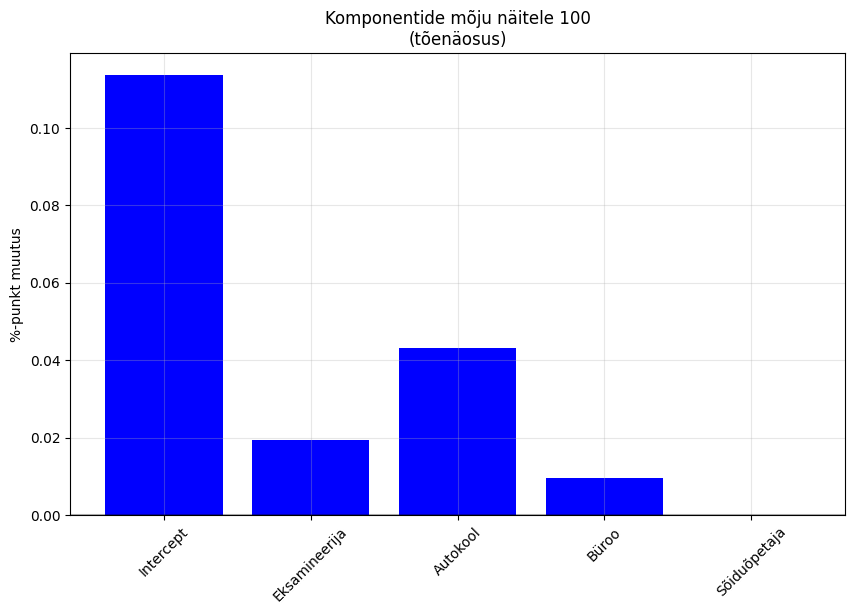

In [68]:
plot_effects_breakdown_prob(100)

## Examiner effects

In [69]:
examiner_bureau_max = pd.DataFrame(df_b_sub.groupby(['EKSAMINEERIJA'])['BYROO']
                      .value_counts()
                      .groupby(level=0)  # Group by examiner
                      .nlargest(1))    # Get largest count for each examiner
examiner_bureau_max.unstack()

count                               \
BYROO                             Rakvere  Pärnu  Narva Tallinn  Jõhvi   
EKSAMINEERIJA    EKSAMINEERIJA                                           
075e15cf091d347b 075e15cf091d347b   689.0    NaN    NaN     NaN    NaN   
12ed0758e403a7d6 12ed0758e403a7d6     NaN  328.0    NaN     NaN    NaN   
147b5bf6bba0d0f1 147b5bf6bba0d0f1  1085.0    NaN    NaN     NaN    NaN   
166c8268fe1b2ec1 166c8268fe1b2ec1     NaN    NaN  716.0     NaN    NaN   
16ff08c229c6ea58 16ff08c229c6ea58     NaN    NaN    NaN    96.0    NaN   
213d8a3fa533a2ce 213d8a3fa533a2ce    40.0    NaN    NaN     NaN    NaN   
22b4bbeee5e023b3 22b4bbeee5e023b3     NaN    NaN    NaN    12.0    NaN   
268b141c418a500d 268b141c418a500d     NaN    NaN    NaN     NaN  197.0   
2bf951502cbf7e6b 2bf951502cbf7e6b     NaN    NaN    NaN    74.0    NaN   
31451a368e962058 31451a368e962058     NaN    NaN    NaN     NaN    NaN   
32a030820e9d4091 32a030820e9d4091   863.0    NaN    NaN     NaN    NaN   
3d6f4cd3cca10b28 3d6f4cd3cca10b28     NaN    NaN    NaN   154.0    NaN   
400e86ed874ccd07 400e86ed874ccd07     NaN    NaN    NaN    89.0    NaN   
40bcf2cea820fca6 40bcf2cea820fca6     NaN    NaN    NaN     NaN    NaN   
4141299ff500eb11 4141299ff500eb11   948.0    NaN    NaN     NaN    NaN   
4b9e369e12d8f969 4b9e369e12d8f969     NaN    NaN    NaN   488.0    NaN   
4ee4a4702131dac3 4ee4a4702131dac3     NaN    NaN    NaN  1646.0    NaN   
5c9ee299be483144 5c9ee299be483144     NaN    NaN    NaN   718.0    NaN   
5f2e29794998d365 5f2e29794998d365     NaN    NaN    NaN     NaN    NaN   
602d00a56a9a8757 602d00a56a9a8757     NaN    NaN    NaN     NaN    NaN   
844452b4e4bac2ef 844452b4e4bac2ef     NaN    NaN    NaN     NaN    NaN   
9f3e3d07ecb6a86c 9f3e3d07ecb6a86c     NaN    NaN    NaN   174.0    NaN   
a1d9e404aeec83d1 a1d9e404aeec83d1     NaN    NaN    NaN   686.0    NaN   
a37826c7bbe98142 a37826c7bbe98142     NaN    NaN    NaN     NaN    NaN   
a90a6cc35a006268 a90a6cc35a006268     NaN    NaN    NaN     NaN    NaN   
ae264be409f2ca9f ae264be409f2ca9f     NaN    NaN    NaN     NaN    NaN   
b353c311e671711a b353c311e671711a     NaN    NaN    NaN     1.0    NaN   
b3e368548c216eb8 b3e368548c216eb8     NaN    NaN    NaN  1302.0    NaN   
b6982cbd7a6000e4 b6982cbd7a6000e4     NaN    NaN    NaN    85.0    NaN   
b89f5e763b05e7a7 b89f5e763b05e7a7     NaN    NaN    NaN     NaN    NaN   
baa43a4ad02e3a60 baa43a4ad02e3a60     NaN    NaN    NaN    17.0    NaN   
be39b89bc70a335e be39b89bc70a335e     NaN    NaN    NaN   233.0    NaN   
bf2b7218d36e2a3d bf2b7218d36e2a3d     NaN    NaN    NaN     NaN    NaN   
c347692cf48342d6 c347692cf48342d6     NaN  527.0    NaN     NaN    NaN   
c6d0f1ea0c1f7aec c6d0f1ea0c1f7aec     NaN    NaN    NaN    52.0    NaN   
c74b0de43bcd0b0f c74b0de43bcd0b0f     NaN    NaN    NaN     NaN  971.0   
cee792f71833b03b cee792f71833b03b     NaN    NaN    NaN     NaN    NaN   
d15d81b55baf64ed d15d81b55baf64ed     NaN    NaN    NaN  1764.0    NaN   
d321254aa86edd96 d321254aa86edd96     NaN    NaN    NaN     NaN    NaN   
e14095bf73a253c7 e14095bf73a253c7     NaN    NaN    NaN     NaN    NaN   
ea58f592917668cf ea58f592917668cf     NaN    NaN    NaN     NaN    NaN   
eb13365f3504e035 eb13365f3504e035     NaN    NaN    NaN   642.0    NaN   
faeaf99580d6be30 faeaf99580d6be30     NaN    NaN    NaN     NaN    NaN   
ff4d9b9b519322e3 ff4d9b9b519322e3     NaN  331.0    NaN     NaN    NaN   

                                                                              \
BYROO                             Haapsalu  Tartu Viljandi  Paide Kuressaare   
EKSAMINEERIJA    EKSAMINEERIJA                                                 
075e15cf091d347b 075e15cf091d347b      NaN    NaN      NaN    NaN        NaN   
12ed0758e403a7d6 12ed0758e403a7d6      NaN    NaN      NaN    NaN        NaN   
147b5bf6bba0d0f1 147b5bf6bba0d0f1      NaN    NaN      NaN    NaN        NaN   
166c8268fe1b2ec1 166c8268fe1b2ec1      NaN    NaN      NaN    NaN        NaN 

In [70]:
examiner_bureau_max=examiner_bureau_max.reset_index(level=0) 
examiner_bureau_max.head()

,,EKSAMINEERIJA,count
EKSAMINEERIJA,BYROO,,
075e15cf091d347b,Rakvere,075e15cf091d347b,689
12ed0758e403a7d6,Pärnu,12ed0758e403a7d6,328
147b5bf6bba0d0f1,Rakvere,147b5bf6bba0d0f1,1085
166c8268fe1b2ec1,Narva,166c8268fe1b2ec1,716
16ff08c229c6ea58,Tallinn,16ff08c229c6ea58,96


Number of examiner_idx with significant positive effect: 6
Number of examiner_idx with significant negative effect: 6


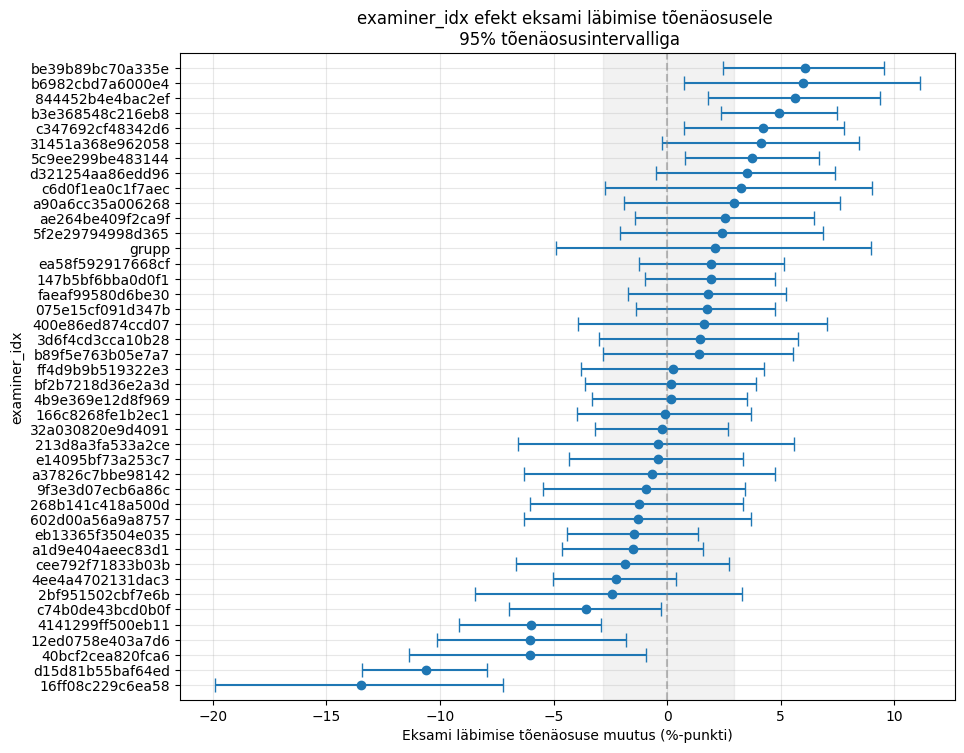

In [71]:
def plot_effects(y_labels_col='examiner_idx', effects_key='examiner_effects', only_significant=False,
                y_dict=None, return_data=False):
# Get all samples for examiner effects
    examiner_samples = trace.posterior[effects_key]
    
    # Get examiner IDs (assuming they're in the original order in df_b_sub)
    examiner_ids = df_b_sub[y_labels_col].unique()
    
    # Calculate mean and HDI for each examiner
    means = []
    hdis = []
    ids = []  # Store IDs in same order as effects
    labels=[]
    
     # Convert logit effects to probability changes
    base_prob = sp.expit(intercept_effect_mean)
    # Calculate baseline CI once
    intercept_samples = trace.posterior['intercept'].values.flatten()
    base_probs = sp.expit(intercept_samples)
    base_ci = np.percentile(base_probs, [2.5, 97.5])
    
    for i in range(examiner_samples.shape[2]):
        effect_samples = examiner_samples[:, :, i].values.flatten()
        prob_changes = sp.expit(intercept_effect_mean + effect_samples) - base_prob
        percentiles = np.percentile(prob_changes, [2.5, 97.5])
        
        # Check for significance considering baseline CI overlap
        is_significant = False
        if percentiles[1] < -base_ci[1] + base_prob:  # Significantly negative
            is_significant = True
        elif percentiles[0] > -base_ci[0] + base_prob:  # Significantly positive
            is_significant = True
            
        if only_significant and is_significant:
            means.append(np.mean(prob_changes))
            hdis.append(percentiles)
            ids.append(examiner_ids[i])
            if y_dict is not None:
                labels.append(y_dict[examiner_ids[i]])
        elif not only_significant:
            means.append(np.mean(prob_changes))
            hdis.append(percentiles)
            ids.append(examiner_ids[i])
            if y_dict is not None:
                labels.append(y_dict[examiner_ids[i]])
    
    # Sort by mean effect
    sorted_indices = np.argsort(means)
    means = np.array(means)[sorted_indices]
    hdis = np.array(hdis)[sorted_indices]
    ids = np.array(ids)[sorted_indices]
    if len(labels)>0:
        labels = np.array(labels)[sorted_indices]
    
    # Calculate confidence interval for baseline probability
    intercept_samples = trace.posterior['intercept'].values.flatten()
    base_probs = sp.expit(intercept_samples)
    base_ci = np.percentile(base_probs, [2.5, 97.5])
    
    # Plot
    plt.figure(figsize=(10, len(means)*0.2))
    
    # Add shaded confidence interval around zero
    plt.axvspan((-base_ci[1] + base_prob)*100, (-base_ci[0] + base_prob)*100, 
                color='grey', alpha=0.1, label='Baseline CI')
    
    # Plot effects
    plt.errorbar(means*100, range(len(means)),
                xerr=[(means - hdis[:, 0])*100, (hdis[:, 1] - means)*100],
                fmt='o', capsize=5)
    plt.axvline(x=0, color='grey', linestyle='--', alpha=0.5)
       
    if y_dict is not None:
        plt.yticks(range(len(means)), labels)
    else:
        plt.yticks(range(len(means)), ids)
    plt.ylim(-1.0, len(means))  # This removes the extra space
    
    plt.ylabel(y_labels_col)
    plt.xlabel('Eksami läbimise tõenäosuse muutus (%-punkti)')
    plt.title(f'{y_labels_col} efekt eksami läbimise tõenäosusele \n 95% tõenäosusintervalliga')
    plt.grid(True, alpha=0.3)
    
    # Print summary statistics
    print(f"Number of {y_labels_col} with significant positive effect: {sum(hdis[:, 0] > 0)}")
    print(f"Number of {y_labels_col} with significant negative effect: {sum(hdis[:, 1] < 0)}")
    if return_data:
        df=pd.DataFrame(hdis)
        df.columns=['low', 'high']
        df['mean']=means
        df['id']=ids
        if len(labels)>0:
            df['label']=labels
        return df
    
df_examiner=plot_effects(y_dict=idx_to_examiner, return_data=True)

Number of examiner_idx with significant positive effect: 0
Number of examiner_idx with significant negative effect: 3


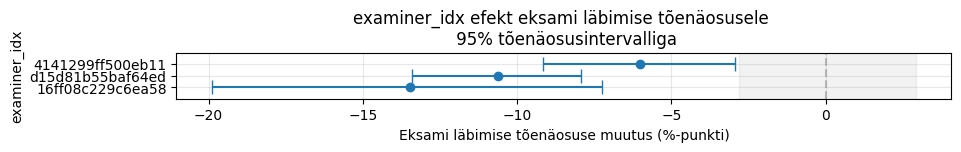

In [72]:
plot_effects(y_dict=idx_to_examiner, only_significant=True, return_data=False)

In [73]:
df_examiner_count=pd.DataFrame(df_b_sub['EKSAMINEERIJA'].value_counts())
df_examiner_count.shape

(44, 1)

In [74]:
df_examiner=df_examiner.merge(df_examiner_count, left_on='label', right_index=True, how='left')
df_examiner=df_examiner.merge(examiner_bureau_max[['count']].reset_index(),  left_on='label', right_on='EKSAMINEERIJA', how='left')
df_examiner.shape

(42, 9)

<Axes: xlabel='mean', ylabel='count_x'>

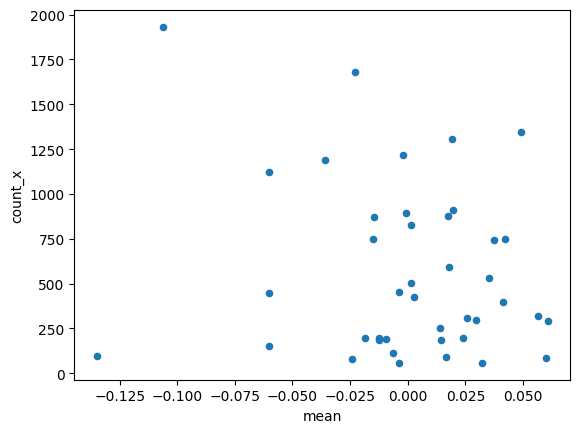

In [75]:
#number of exams vs mean effect
df_examiner.plot.scatter('mean', 'count_x')

/tmp/ipykernel_204/3790301084.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df_examiner[mask]['mean'],


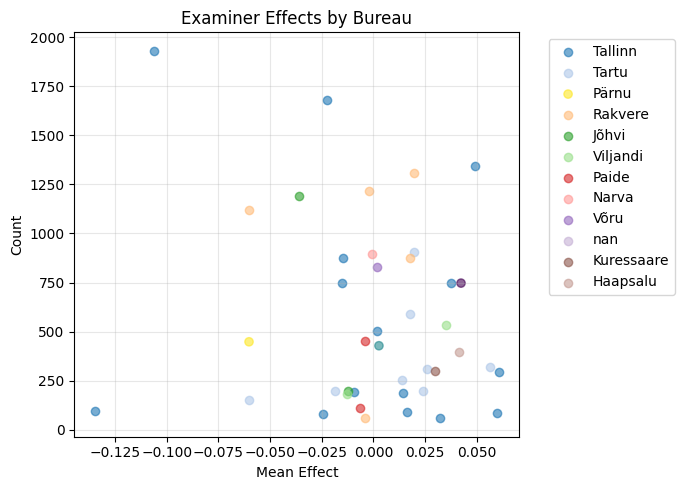

In [76]:
# Create color mapping for BYROO
unique_byroos = df_examiner['BYROO'].unique()
color_map = dict(zip(unique_byroos, plt.cm.tab20.colors[:len(unique_byroos)]))

# Create the plot
plt.figure(figsize=(7, 5))
for byroo in unique_byroos:
    mask = df_examiner['BYROO'] == byroo
    plt.scatter(df_examiner[mask]['mean'], 
               df_examiner[mask]['count_x'],
               label=byroo,
               c=color_map[byroo],
               alpha=0.6)

plt.xlabel('Mean Effect')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Examiner Effects by Bureau')
plt.grid(True, alpha=0.3)
plt.tight_layout()

## School effects

In [77]:
df_b_sub.VIIMANE_AUTOKOOL.str.lower().nunique()

77

Number of school_idx with significant positive effect: 0
Number of school_idx with significant negative effect: 2


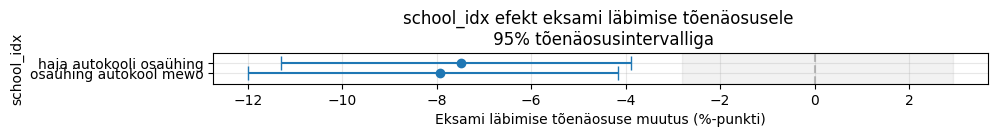

In [78]:
df_school=plot_effects(y_labels_col='school_idx', effects_key='school_effects', only_significant=True,
             y_dict=idx_to_school, return_data=True)

In [79]:
df_school.sort_values('mean')

,low,high,mean,id,label
0,-0.119916,-0.041659,-0.079397,19,osaühing autokool mewo
1,-0.112919,-0.038886,-0.074839,39,haja autokooli osaühing


Number of school_idx with significant positive effect: 4
Number of school_idx with significant negative effect: 3


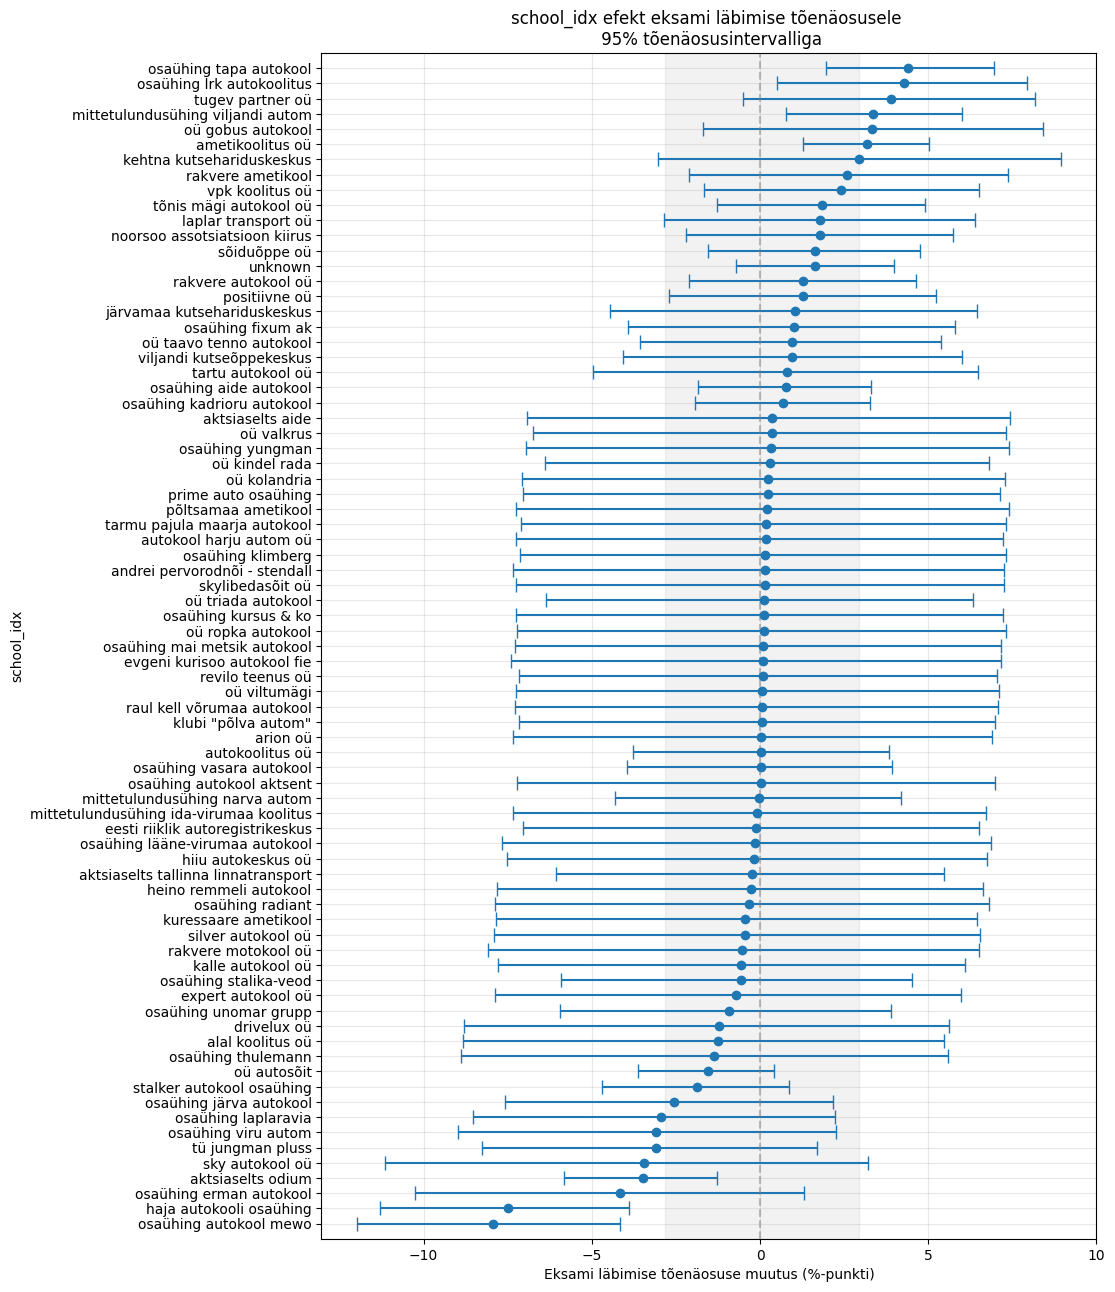

In [80]:
df_school=plot_effects(y_labels_col='school_idx', effects_key='school_effects', only_significant=False,
             y_dict=idx_to_school, return_data=True)

## Büroo effects

Number of byroo_idx with significant positive effect: 0
Number of byroo_idx with significant negative effect: 1


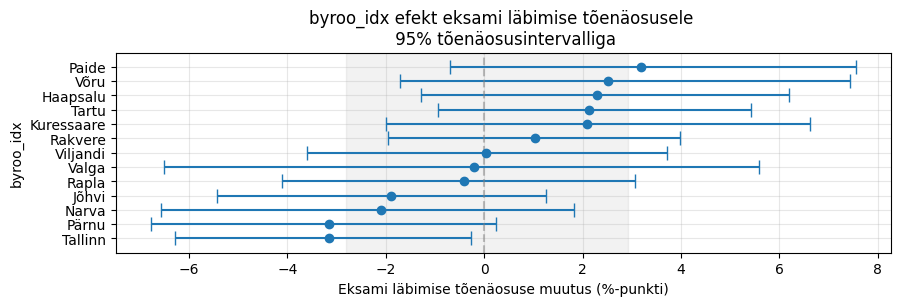

In [81]:
plot_effects(y_labels_col='byroo_idx', effects_key='byroo_effects', only_significant=False,
             y_dict=idx_to_byroo)

## Teacher present

In [82]:
def plot_binary_effects(binary_effects=['teacher_effect'],
                       effect_labels=['Sõiduõpetaja kaasas']):
    # Calculate mean and HDI for each binary effect
    means = []
    hdis = []
    
    # Convert logit effects to probability changes
    base_prob = sp.expit(intercept_effect_mean)
    
    for effect_name in binary_effects:
        effect_samples = trace.posterior[effect_name].values.flatten()
        prob_changes = sp.expit(intercept_effect_mean + effect_samples) - base_prob
        
        means.append(np.mean(prob_changes))
        hdis.append(np.percentile(prob_changes, [2.5, 97.5]))
    
    # Convert to arrays
    means = np.array(means)
    hdis = np.array(hdis)
    
    # Calculate confidence interval for baseline probability
    intercept_samples = trace.posterior['intercept'].values.flatten()
    base_probs = sp.expit(intercept_samples)
    base_ci = np.percentile(base_probs, [2.5, 97.5])
    
    # Plot
    plt.figure(figsize=(10, len(means)*0.5))
    
    # Add shaded confidence interval around zero
    plt.axvspan((-base_ci[1] + base_prob)*100, (-base_ci[0] + base_prob)*100, 
                color='grey', alpha=0.1, label='Baseline CI')
    
    # Plot effects
    plt.errorbar(means*100, range(len(means)),
                xerr=[(means - hdis[:, 0])*100, (hdis[:, 1] - means)*100],
                fmt='o', capsize=5, markersize=10)
    plt.axvline(x=0, color='grey', linestyle='--', alpha=0.5)
    
    # Add effect labels
    plt.yticks(range(len(means)), effect_labels)
    plt.ylim(-0.5, len(means)-0.5)
    
    # plt.ylabel('Binary Effects')
    plt.xlabel('Eksami läbimise tõenäosuse muutus (%-punkti)')
    plt.title('mõju eksami läbimise tõenäosusele \n 95% tõenäosusintervalliga')
    plt.grid(True, alpha=0.3)
    
    # Print summary statistics
    print("Significant effects:")
    for label, hdi in zip(effect_labels, hdis):
        if hdi[0] > 0:
            print(f"{label}: Significant positive effect")
        elif hdi[1] < 0:
            print(f"{label}: Significant negative effect")
        else:
            print(f"{label}: No significant effect")

Significant effects:
Sõiduõpetaja kaasas: No significant effect


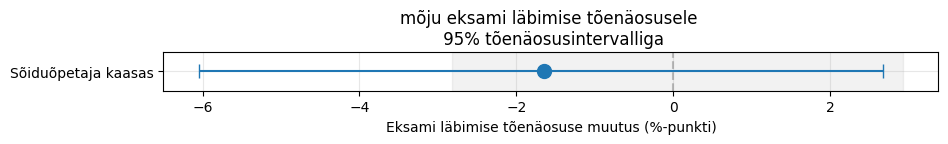

In [83]:
plot_binary_effects()

## Predict on training data to get estimate on accuracy

In [84]:
# Get posterior means
examiner_effects_mean = trace.posterior['examiner_effects'].mean(dim=('chain', 'draw'))
school_effects_mean = trace.posterior['school_effects'].mean(dim=('chain', 'draw'))
byroo_effects_mean = trace.posterior['byroo_effects'].mean(dim=('chain', 'draw'))
teacher_effect_mean = trace.posterior['teacher_effect'].mean(dim=('chain', 'draw'))
intercept_effect_mean = float(trace.posterior['intercept'].mean())

def effects_breakdown_prob(sample_idx):
    # Get base effects (logit scale)
    effects = {
        'Intercept': intercept_effect_mean,
        'Examiner': examiner_effects_mean[df_b_sub['examiner_idx'].iloc[sample_idx]],
        'School': school_effects_mean[df_b_sub['school_idx'].iloc[sample_idx]],
        'Bureau': byroo_effects_mean[df_b_sub['byroo_idx'].iloc[sample_idx]],
        'Teacher' : teacher_effect_mean*df_b_sub['teacher_present_c'].iloc[sample_idx]
    }
    
    # Convert to probability changes
    prob_changes = {}
    cumulative = 0
    for k, v in effects.items():
        prev_prob = sp.expit(cumulative)
        cumulative += v
        new_prob = sp.expit(cumulative)
        res= (new_prob - prev_prob)
        if k=='Intercept':
            prob_changes[k] = res#[0]
        else:
            prob_changes[k] = float(res.data)#[0]
            
    
    return prob_changes


In [85]:
preds=[]
for i in range(df_b_sub.shape[0]):
    res_=effects_breakdown_prob(i)
    preds.append(res_)

In [86]:
df_b_sub['pred_raw']=preds
df_b_sub['pred_sum']=df_b_sub['pred_raw'].apply(lambda x: np.sum(list(x.values())))
df_b_sub['pred']=np.where(df_b_sub['pred_sum']>0., 1, 0)

In [87]:
np.sum(list(res_.values()))

0.1998090531435721

In [88]:
print(classification_report(df_b_sub.y, df_b_sub.pred))

              precision    recall  f1-score   support

         0.0       0.58      0.17      0.26      6822
         1.0       0.73      0.95      0.83     16330

    accuracy                           0.72     23152
   macro avg       0.66      0.56      0.54     23152
weighted avg       0.69      0.72      0.66     23152



## individual max effects

In [89]:
pd.DataFrame(df_b_sub.pred_raw.tolist())

,Intercept,Examiner,School,Bureau,Teacher
0,0.113692,-0.022591,-0.035334,-0.032534,0.000170
1,0.113692,-0.015053,-0.035163,-0.032446,0.000170
2,0.113692,0.014148,0.023906,0.020434,0.000150
3,0.113692,0.014148,0.023906,0.020434,0.000150
4,0.113692,0.041898,0.012223,0.021471,0.000146
...,...,...,...,...,...
23147,0.113692,0.014148,-0.015270,0.021442,0.000158
23148,0.113692,0.042574,0.007543,-0.029764,0.000158
23149,0.113692,-0.012103,0.018718,-0.018706,0.000163
23150,0.113692,-0.035700,-0.015889,-0.019459,0.000169


## Save model data

In [51]:
# def clean_name_for_js(name):
#     """Clean names for JavaScript use, preserving Estonian characters"""
#     if pd.isna(name):
#         return "Unknown"
    
#     # Convert to string if not already
#     name = str(name)
    
#     # Preserve Estonian characters while replacing problematic ones
#     estonian_chars = {
#         'õ': 'õ', 'ä': 'ä', 'ö': 'ö', 'ü': 'ü',
#         'Õ': 'Õ', 'Ä': 'Ä', 'Ö': 'Ö', 'Ü': 'Ü',
#         'š': 'š', 'ž': 'ž', 'Š': 'Š', 'Ž': 'Ž'
#     }
    
#     # Replace problematic characters but keep Estonian ones
#     replacements = {
#         # '"': '&quot;',
#         # "'": '&apos;',
#         '<': '&lt;',
#         '>': '&gt;',
#         '\\': '',
#         '\n': ' ',
#         '\r': ' ',
#         '\t': ' '
#     }
    
#     # First preserve Estonian characters
#     for est_char in estonian_chars:
#         name = name.replace(est_char, f"____{est_char}____")
    
#     # Then replace problematic characters
#     for char, replacement in replacements.items():
#         name = name.replace(char, replacement)
    
#     # Restore Estonian characters
#     for est_char in estonian_chars:
#         name = name.replace(f"____{est_char}____", est_char)
    
#     # Remove multiple spaces
#     name = ' '.join(name.split())
    
#     return name

# def save_model_to_json(trace, output_file='model_data.js', ci_width=0.95):
#     # Get all samples for uncertainty calculations
#     examiner_samples = trace.posterior['examiner_effects'].values
#     school_samples = trace.posterior['school_effects'].values
#     byroo_samples = trace.posterior['byroo_effects'].values
#     teacher_samples = trace.posterior['teacher_effect'].values
#     intercept_samples = trace.posterior['intercept'].values
    
#     def get_effect_stats(samples):
#         mean = np.mean(samples, axis=(0,1))
#         ci_lower = np.percentile(samples, (1-ci_width)*100/2, axis=(0,1))
#         ci_upper = np.percentile(samples, 100-(1-ci_width)*100/2, axis=(0,1))
#         return mean, ci_lower, ci_upper
    
#     # Get effects and CIs
#     examiner_effects, examiner_ci_lower, examiner_ci_upper = get_effect_stats(examiner_samples)
#     school_effects, school_ci_lower, school_ci_upper = get_effect_stats(school_samples)
#     byroo_effects, byroo_ci_lower, byroo_ci_upper = get_effect_stats(byroo_samples)
    
#     examiner_map = {idx: clean_name_for_js(name) 
#                    for idx, name in enumerate(df_b_sub['EKSAMINEERIJA'].unique())}
#     school_map = {idx: clean_name_for_js(name) 
#                  for idx, name in enumerate(df_b_sub['VIIMANE_AUTOKOOL'].unique())}
#     byroo_map = {idx: clean_name_for_js(name) 
#                 for idx, name in enumerate(df_b_sub['BYROO'].unique())}
    
#     model_data = {
#         'intercept': float(np.mean(intercept_samples)),
#         'intercept_ci': [float(np.percentile(intercept_samples, 2.5)), 
#                         float(np.percentile(intercept_samples, 97.5))],
#         'examiner_effects': {
#             examiner_map[i]: {
#                 'effect': float(effect),
#                 'ci_lower': float(ci_lower),
#                 'ci_upper': float(ci_upper)
#             } for i, (effect, ci_lower, ci_upper) in enumerate(zip(examiner_effects, 
#                                                                  examiner_ci_lower, 
#                                                                  examiner_ci_upper))
#         },
#         'school_effects': {  # Add school effects
#             school_map[i]: {
#                 'effect': float(effect),
#                 'ci_lower': float(ci_lower),
#                 'ci_upper': float(ci_upper)
#             } for i, (effect, ci_lower, ci_upper) in enumerate(zip(school_effects, 
#                                                                  school_ci_lower, 
#                                                                  school_ci_upper))
#         },
#         'byroo_effects': {  # Add byroo effects
#             byroo_map[i]: {
#                 'effect': float(effect),
#                 'ci_lower': float(ci_lower),
#                 'ci_upper': float(ci_upper)
#             } for i, (effect, ci_lower, ci_upper) in enumerate(zip(byroo_effects, 
#                                                                  byroo_ci_lower, 
#                                                                  byroo_ci_upper))
#         },
#         'teacher_effect': float(np.mean(teacher_samples)),
#         'teacher_ci': [float(np.percentile(teacher_samples, 2.5)), 
#                       float(np.percentile(teacher_samples, 97.5))],
#         'teacher_mean': float(df_b_sub['teacher_present_c'].mean()),
#         'examiner_names': list(examiner_map.values()),
#         'school_names': list(school_map.values()),
#         'byroo_names': list(byroo_map.values())
#     }

#     with open(output_file, 'w', encoding='utf-8') as f:  # Note: utf-8 encoding
#         f.write('const modelData = ')
#         json.dump(model_data, f, indent=2, ensure_ascii=False)  # ensure_ascii=False for proper encoding
#         f.write(';')

        
# save_model_to_json(trace)